### Imports

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import sys
#print("Name of the script: ", sys.argv[0])
#print("Number of arguments: ", len(sys.argv))
#print("The arguments are: ", str(sys.argv))
import time
import numpy as np
import pandas as pd
#pd.show_versions()
#print (pd.__version__)
pd.options.display.max_rows = 1000000
pd.options.display.max_columns = 1000000
pd.options.display.width = 1000000
#pd.options.display.max_colwidth = 1000000
import matplotlib.pyplot as plt
import datetime
import pytz
from pytz import timezone
from datetime import datetime
import matplotlib.ticker as ticker
from scipy.stats import norm
import csv
import random

def print_full(x):
   pd.set_option('display.max_rows', len(x))
   print(x)
   pd.reset_option('display.max_rows')

print("...")

...


## Import and transform the data

In [3]:

# Before running this script do:
# export GIO_EXTRA_MODULES=/usr/lib/x86_64-linux-gnu/gio/modules/
# in order to successfully visualize the plots.

#######################################################################################################################
# INPUT AND TRANSFORM THE DATA
#######################################################################################################################
# Read the data into a DataFrame (the original input file has been slightly edited):
original_df = pd.read_json('Donnees_Louvre_Zones_FORMATTED.json')
# The DataFrame's index allows access to each visit recorded in the log file:
#print(original_df.iloc[0])
#print(original_df.iloc[1])
# ...

# Dictionaries are one of python's default data structures which allow to store "key: value" pairs.
# Panda's Series are one-dimensional ndarrays (numpy built-in structures) with axis-labels, which allow to store array-like, dict, or scalar values.

# From the "original_df" dataframe we create two dataframes: one containing per visit data ("visits_df") and one containing per zone data ("zones_df")
ut = timezone('UTC')
visits_df = pd.DataFrame(columns = ["Id", "User Id", "Begin At", "Duration", "Positions", "Zones"])
zone_list2 = []
new_zone_list = [] # a list holding a lists of zones id of each visit, new_zone_list=[[zoneId1, zoneId2, ...],[zoneId1, zoneId2, ...], ...]
for index, visit in original_df._source.iteritems():
   #print('index:', index, 'Visit Id:', original_df.loc[index,'_id'], ',User Id:', visit['user_id'], ',Visit Begin:', visit['visit_begin'], ',Visit Duration:', visit['visit_duration'], ',Number of Positions:', visit['number_of_positions'])
   #visits_df.set_value(index, 'Id', original_df.loc[index,'_id']) # Deprecated
   visits_df.at[index, 'Id'] = original_df.loc[index,'_id']
   if 'user_id' in visit: # alternatively  we could pre-process the input data to not distinguish between 'user_id' and 'userId' and then do a simple: visits_df.set_value(index, 'User Id', visit['user_id'])
      #visits_df.set_value(index, 'User Id', visit['user_id']) # Deprecated
      visits_df.at[index, 'User Id'] = visit['user_id']
   elif 'userId' in visit:
      #visits_df.set_value(index, 'User Id', visit['userId']) # Deprecated
      visits_df.at[index, 'User Id'] = visit['userId']
   #visits_df.set_value(index, 'Begin At', (pd.to_datetime(visit['visit_begin']))) # Deprecated
   visits_df.at[index, 'Begin At'] = pd.to_datetime(visit['visit_begin'])
   #visits_df.set_value(index, 'Begin At', visit['visit_begin']) # if we alternatively wanted to treat it as text # Deprecated
   #visits_df.at[index, 'Begin At'] = visit['visit_begin']       # if we alternatively wanted to treat it as text
   #visits_df.set_value(index, 'Duration', visit['visit_duration']) # Deprecated
   visits_df.at[index, 'Duration'] = visit['visit_duration']
   #visits_df.set_value(index, 'Positions', visit['number_of_positions']) # Deprecated
   visits_df.at[index, 'Positions'] = visit['number_of_positions']
   #visits_df.set_value(index, 'Zones', []) # Deprecated
   visits_df.at[index, 'Zones'] = []
   zone_list1 = [] # temporary list to help create the 'Zones' column of the "visits_df" dataframe.
   list = [] # temporary list that holds the zones id of one visist
   for zone in visit['visit_times_zones'][:]:
      list.append(zone['zone']['id'])
      #print('Begin At:', zone['begin_at'], ',Zone Id:', zone['zone']['id'], ',Zone Name:', zone['zone']['name'],  ',Zone Level:', zone['zone']['level'], ',Duration:', zone['duration'])
      # Iteratively populate the "zone_list1" and "zone_list2" structures (NOTE: the timestamps - originally timezone unaware - now get localized as UTC):
      if 'nextZone' in zone.keys():
         zone_list1.append({"ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": zone['nextZone']})
         if 'user_id' in visit: # instead of this if condition we could pre-process the input data to include only 'user_id' or 'userId'
            zone_list2.append({"VisitId": original_df.loc[index,'_id'], "UserId": visit['user_id'], "VisitDuration": visit['visit_duration'], "VisitPositions": visit['number_of_positions'], "ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": zone['nextZone']})
         else: # 'userId' in visit
            zone_list2.append({"VisitId": original_df.loc[index,'_id'], "UserId": visit['userId'], "VisitDuration": visit['visit_duration'], "VisitPositions": visit['number_of_positions'], "ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": zone['nextZone']})
      else:
         zone_list1.append({"ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": 'none'})
         if 'user_id' in visit: # instead of this if we could pre-process the input data to have only one of 'user_id' or 'userId'
            zone_list2.append({"VisitId": original_df.loc[index,'_id'], "UserId": visit['user_id'], "VisitDuration": visit['visit_duration'], "VisitPositions": visit['number_of_positions'], "ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": 'none'})
         else: # 'userId' in visit
            zone_list2.append({"VisitId": original_df.loc[index,'_id'], "UserId": visit['userId'], "VisitDuration": visit['visit_duration'], "VisitPositions": visit['number_of_positions'], "ZoneBeginAt": (pd.to_datetime(zone['begin_at'])).astimezone('UTC'), "ZoneId": zone['zone']['id'], "ZoneName": zone['zone']['name'], "ZoneLevel": zone['zone']['level'], "ZoneDuration": zone['duration'], "NextZoneId": 'none'})
   #visits_df.set_value(index, 'Zones', zone_list1) # Deprecated
   visits_df.at[index, 'Zones'] = zone_list1
   new_zone_list.append(list)
zones_df = pd.DataFrame(zone_list2, columns=["UserId", "VisitId", "VisitDuration", "VisitPositions", "ZoneName", "ZoneLevel", "ZoneId", "ZoneBeginAt", "ZoneDuration", "NextZoneId"]) # Use "zone_list2" for "zones_df".

# We add the "ZoneDurationWithGap" column to the "zones_df" dataframe:
# Its values are equal to the duration between the "BeginAt" timestamps of each zone and its subsequent zone
# It represents the sum of "ZoneDuration" + non-detection gap (if any)
for index, row in zones_df.iterrows():
   if row['NextZoneId'] != "none":
      zones_df.at[index,'ZoneDurationWithGap'] = (zones_df.at[index+1,'ZoneBeginAt'] - zones_df.at[index,'ZoneBeginAt']).total_seconds()
   else:
      zones_df.at[index,'ZoneDurationWithGap'] = zones_df.at[index,'ZoneDuration']
zones_df['ZoneDurationWithGap'] = zones_df['ZoneDurationWithGap'].astype(int) # forcing float values to become int values

print("import finished ...")

import finished ...


## Co-occurrence

In [4]:
from apyori import apriori

association_rules = apriori(new_zone_list, min_support=0.0045, min_confidence=0.2, min_lift=3, min_length=2)

nbr_items_print = 5

for item in association_rules:
    if nbr_items_print == 0:
        break
    nbr_items_print -= 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0]
    items = [x for x in pair]
    print("Rule: " + str(items[0]) + " -> " + str(items[1]))

    #second index of the inner list
    print("Support: " + str(item[1]))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")


Rule: 60852 -> 60839
Support: 0.008493427704752275
Confidence: 0.5060240963855422
Lift: 3.074065302980966
Rule: 60853 -> 60839
Support: 0.008493427704752275
Confidence: 0.5060240963855422
Lift: 3.418427809599052
Rule: 60846 -> 60847
Support: 0.028311425682507583
Confidence: 0.440251572327044
Lift: 9.22476281846285
Rule: 60848 -> 60846
Support: 0.013751263902932255
Confidence: 0.21383647798742136
Lift: 3.887578616352201
Rule: 60849 -> 60846
Support: 0.030333670374115267
Confidence: 0.4716981132075471
Lift: 6.425749779094548


## Trasition Matrix
This matrix contains all the transitions stored in Donnees_Louvre_Zones_FORMATTED.json file.<br>
The value stored in matrix[i, j] represents the probability to transit from zone j to zone i based on the trajectories of visitors stored in our data. 
For each visit, we take sequential visited zones two by two, and we add 1 to the value stored in matrix[departure zone, arival zone]<br>
At the end we devide each value by the sum of the row to provide a tochastic matrix

In [5]:
zones_N1 = ['0'] # used to initialize the data frame
nbr_arcs = {} # nbr of transitions from the from_zone, in order to calculate the average
trasition_matrix = pd.DataFrame( index=zones_N1)

# loop through zones, and add a transition each time.
for index, row in zones_df.iterrows():
   from_zone = str(row['ZoneId'])
   if  from_zone not in trasition_matrix.index : # Adding new row/column with zeros if it doesn't exist
       trasition_matrix.loc[:, from_zone] = 0.0
       trasition_matrix.loc[from_zone] = 0.0
       nbr_arcs[from_zone] = 0.0

   if row['NextZoneId'] != "none": # if it's note the last zone visited
      to_zone = str(row['NextZoneId'])
      if  to_zone not in trasition_matrix.index : # Adding new row/column with zeros if it doesn't exist
          trasition_matrix.loc[:, to_zone] = 0.0
          trasition_matrix.loc[to_zone] = 0.0
          nbr_arcs[to_zone] = 0.0

      trasition_matrix.at[ from_zone, to_zone ] += 1 # Add the trasition to the value in matrix[from_zone, to_zone]
      nbr_arcs[from_zone] += 1

trasition_matrix = trasition_matrix.drop('0')

# Convert the matrix to a stochastic matrix (sum of values in a row = 1)
for index, row in trasition_matrix.iterrows():
    trasition_matrix.loc[index] = [round(value/nbr_arcs[index], 6) for value in row]

#print(trasition_matrix.loc[:,:].sum(axis=1)) # to make sure it is a stochastic matrix

print("matrix shape : ",trasition_matrix.shape)
print("Transition matrix smaple :")
trasition_matrix.iloc[:10,:]

#df.to_csv('trasition_matrix.csv', index=True, header=True, sep=' ') # write matrix to a csv file

matrix shape :  (30, 30)
Transition matrix smaple :


,60890,60888,60852,60902,60904,60853,60854,60839,60849,60903,60906,60891,60908,60892,60910,60896,60895,60848,60887,60909,60850,60889,60907,60893,60851,60846,60855,60847,60894,60911
60890,0.000000,0.666667,0.013889,0.000000,0.000000,0.013889,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,0.055556,0.000000,0.013889,0.000000,0.000000,0.000000,0.125000,0.041667,0.013889,0.013889,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000
60888,0.110429,0.000000,0.019939,0.044479,0.009202,0.194785,0.058282,0.009202,0.016871,0.003067,0.004601,0.000000,0.012270,0.007669,0.093558,0.010736,0.010736,0.016871,0.115031,0.006135,0.021472,0.131902,0.004601,0.003067,0.064417,0.010736,0.001534,0.018405,0.000000,0.000000
60852,0.000000,0.014156,0.000000,0.054601,0.250758,0.185035,0.010111,0.012133,0.004044,0.058645,0.040445,0.002022,0.002022,0.001011,0.003033,0.000000,0.000000,0.000000,0.000000,0.002022,0.006067,0.000000,0.003033,0.003033,0.340748,0.002022,0.003033,0.001011,0.000000,0.001011
60902,0.000976,0.008780,0.087805,0.000000,0.081951,0.310244,0.324878,0.000000,0.000976,0.007805,0.007805,0.003902,0.000976,0.001951,0.005854,0.000000,0.000976,0.000976,0.000000,0.003902,0.002927,0.000976,0.000000,0.000000,0.009756,0.000000,0.011707,0.000000,0.000000,0.124878
60904,0.000000,0.008562,0.315068,0.145548,0.000000,0.068493,0.005137,0.000000,0.000000,0.212329,0.191781,0.003425,0.001712,0.001712,0.001712,0.000000,0.000000,0.000000,0.000000,0.001712,0.005137,0.000000,0.008562,0.000000,0.010274,0.000000,0.010274,0.001712,0.000000,0.006849
60853,0.003158,0.035789,0.263158,0.351579,0.075789,0.000000,0.188421,0.020000,0.003158,0.005263,0.006316,0.001053,0.003158,0.000000,0.004211,0.000000,0.000000,0.003158,0.001053,0.000000,0.001053,0.004211,0.000000,0.000000,0.024211,0.002105,0.001053,0.001053,0.000000,0.001053
60854,0.000000,0.020472,0.029921,0.581102,0.011024,0.277165,0.000000,0.003150,0.001575,0.001575,0.001575,0.000000,0.000000,0.000000,0.001575,0.000000,0.000000,0.001575,0.001575,0.001575,0.001575,0.001575,0.000000,0.000000,0.007874,0.001575,0.006299,0.000000,0.000000,0.047244
60839,0.000000,0.042553,0.446809,0.000000,0.000000,0.404255,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.042553,0.000000,0.000000,0.000000,0.042553,0.000000
60849,0.000000,0.022936,0.018349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009174,0.002294,0.043578,0.004587,0.029817,0.002294,0.002294,0.018349,0.004587,0.240826,0.250000,0.004587,0.013761,0.000000,0.098624,0.217890,0.002294,0.013761,0.000000,0.000000
60903,0.000000,0.000000,0.177215,0.075949,0.358650,0.033755,0.012658,0.004219,0.000000,0.000000,0.240506,0.004219,0.000000,0.000000,0.004219,0.000000,0.000000,0.000000,0.000000,0.004219,0.012658,0.000000,0.033755,0.000000,0.008439,0.004219,0.016878,0.000000,0.000000,0.008439


## Weighted matrix
This matrix has the same properties of the Transition matrix, except it stores on top of that the duration with gap of the arival zone. <br>
For each cell (i, j) in the matrix, contains the average duration that a visitor stays in zone j and comed form zone i, this average is devided by sum of the row to keep the matrix normalized (Stochastic).<br>
ps. we only use duration with gap and not the absolute duration


In [6]:
zones_N1 = ['0'] # used to initialize the data frame
nbr_arcs = {} # nbr of transitions from the from_zone, in order to calculate the average
weighted_matrix = pd.DataFrame( index=zones_N1)
i = 500 # used for debuging
# loop through zones, and add a transition each time.
for index, row in zones_df.iterrows():
   from_zone = str(row['ZoneId'])
   if  from_zone not in weighted_matrix.index : # Adding new row/column with zeros if it doesn't exist
       weighted_matrix.loc[:, from_zone] = 0.0
       weighted_matrix.loc[from_zone] = 0.0
       nbr_arcs[from_zone] = 0.0

   if row['NextZoneId'] != "none": # if it's note the last zone visited
      to_zone = str(row['NextZoneId'])
      if  to_zone not in weighted_matrix.index : # Adding new row/column with zeros if it doesn't exist
          weighted_matrix.loc[:, to_zone] = 0.0
          weighted_matrix.loc[to_zone] = 0.0
          nbr_arcs[to_zone] = 0.0
      
      # Add the trasition to the value in matrix[from_zone, to_zone]
      weighted_matrix.at[ from_zone, to_zone ] += zones_df.iloc[index+1]['ZoneDurationWithGap']
      
      # weighted_matrix.at[ from_zone, to_zone ] += zones_df.loc[(zones_df['VisitId'] == row['VisitId']) 
      #                                          & (zones_df['ZoneId'] == row['NextZoneId'])]['ZoneDurationWithGap'].iloc[0]
     
      nbr_arcs[from_zone] += zones_df.iloc[index+1]['ZoneDurationWithGap']
    
      if(i == 0):
          print('.', end ="")  
          i = 500
      i -= 1
        
weighted_matrix = weighted_matrix.drop('0')

# Convert the matrix to a stochastic matrix (sum of values in a row = 1)
for index, row in weighted_matrix.iterrows():
    weighted_matrix.loc[index] = [round(value/nbr_arcs[index], 6) for value in row]

print()

print("matrix shape : ",weighted_matrix.shape)
print("Transition matrix sample :")
weighted_matrix.iloc[:10,:10]

#df.to_csv('weighted_matrix.csv', index=True, header=True, sep=' ') # write matrix to a csv file

..............................
matrix shape :  (30, 30)
Transition matrix sample :


,60890,60888,60852,60902,60904,60853,60854,60839,60849,60903
60890,0.000000,0.415353,0.003672,0.000000,0.000000,0.019181,0.000232,0.000000,0.000000,0.000000
60888,0.060185,0.000000,0.025617,0.041891,0.001805,0.142507,0.113199,0.009336,0.021496,0.001004
60852,0.000000,0.010102,0.000000,0.081194,0.209551,0.151232,0.003386,0.010759,0.003703,0.041261
60902,0.000058,0.026515,0.106638,0.000000,0.096084,0.199542,0.244208,0.000000,0.000000,0.004772
60904,0.000000,0.010525,0.250595,0.185274,0.000000,0.051511,0.007663,0.000000,0.000000,0.212320
60853,0.005240,0.034125,0.275687,0.331149,0.077660,0.000000,0.206255,0.019737,0.006018,0.001231
60854,0.000000,0.025767,0.034842,0.594174,0.006323,0.258773,0.000000,0.005451,0.001284,0.000292
60839,0.000000,0.052970,0.515362,0.000000,0.000000,0.330751,0.000000,0.000000,0.000000,0.000000
60849,0.000000,0.020797,0.041515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
60903,0.000000,0.000000,0.087834,0.059625,0.342566,0.044277,0.009083,0.000120,0.000000,0.000000


## Adjacency matrix
This matrix contains 1 if there is an accessibility between two zones, the data is stored in zone_To_zone.csv file.<br>
This matrix is symetric, so each time we add 1 to (i, j) we add it also to (j, i)<br>
We also modify this matrix to be stochastic for later use.


In [7]:
with open('zone_To_zone.csv', newline='') as csv_file:
    
    zone_to_zone = pd.read_csv(csv_file) # read from file
        
    zones_N1 = ['0'] # used to initialize the data frame
    adjacency_matrix = pd.DataFrame( index=zones_N1)
    
    for index, row in zone_to_zone.iterrows():
        zone1 = str(row['Zone1'])
        if  zone1 not in adjacency_matrix.index : # Adding new row/column with zeros if it doesn't exist
            adjacency_matrix.loc[:, zone1] = 0.0
            adjacency_matrix.loc[zone1] = 0.0
            nbr_arcs[zone1] = 0.0
        
        zone2 = str(row['Zone2'])
        if  zone2 not in adjacency_matrix.index : # Adding new row/column with zeros if it doesn't exist
            adjacency_matrix.loc[:, zone2] = 0.0
            adjacency_matrix.loc[zone2] = 0.0
            nbr_arcs[zone2] = 0.0
        
        adjacency_matrix.at[ zone1, zone2 ] += 1
        adjacency_matrix.at[ zone2, zone1 ] += 1
   
    adjacency_matrix = adjacency_matrix.drop('0')
    
    # Convert the matrix to a stochastic matrix (sum of values in a row = 1)
    for index, row in adjacency_matrix.iterrows():
        adjacency_matrix.loc[index,:] /= adjacency_matrix.loc[index,:].sum()
    
print(adjacency_matrix.shape) 
adjacency_matrix.iloc[:10,:]     

(82, 82)


,60896,60895,60894,60891,60893,70002,70003,60892,60911,60902,65004,60910,60909,70004,70007,70005,60908,70006,60907,70009,70008,60906,70011,60904,70010,60903,65005,65003,65002,65001,60855,70020,60854,70019,70018,60853,70017,60852,60851,60850,70016,60849,70015,70014,60846,60847,70012,65021,65019,65020,65018,65017,70028,70021,70026,65016,70027,65015,65014,70025,65013,65010,65009,65007,65008,70022,70030,70029,70023,70024,60890,60889,65023,60888,60887,65022,60848,65011,65012,70013,65006,60839
60896,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.25,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.25,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
60895,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.25,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
60894,0.00,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
60891,0.00,0.00,0.142857,0.000000,0.000000,0.142857,0.142857,0.142857,0.000000,0.00,0.00,0.00,0.142857,0.00,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
60893,0.00,0.00,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
70002,0.00,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
70003,0.00,0.00,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.000000,0.0,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
60892,0.00,0.00,0.000000,0.166667,0.000000,0.166667,0.166667,0.000000,0.000000,0.00,0.00,0.00,0.166667,0.00,0.0,0.000000,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
60911,0.00,0.00,0.0

## Artificial Matrix
Artificial matrix is the merge the transition matrix and the adjacency matrix.<br>
we sum the two matrix unequally.<br>
<b>alpha</b> is the coeffecient of using the trasition matrix.

In [8]:
alpha = 0.85 # coeffecient of the probability
    
artificial_matrix = adjacency_matrix * (1 - alpha) # copy the adjacency matrix and multiply it by (1 - alpha)


# add the trasition matrix multiplied by alpha
idx = trasition_matrix.index.values
artificial_matrix.loc[idx, idx] += (trasition_matrix.loc[idx,idx] * alpha)

#print(artificial_matrix.sum(axis=1))
artificial_matrix.iloc[:10,:]

,60896,60895,60894,60891,60893,70002,70003,60892,60911,60902,65004,60910,60909,70004,70007,70005,60908,70006,60907,70009,70008,60906,70011,60904,70010,60903,65005,65003,65002,65001,60855,70020,60854,70019,70018,60853,70017,60852,60851,60850,70016,60849,70015,70014,60846,60847,70012,65021,65019,65020,65018,65017,70028,70021,70026,65016,70027,65015,65014,70025,65013,65010,65009,65007,65008,70022,70030,70029,70023,70024,60890,60889,65023,60888,60887,65022,60848,65011,65012,70013,65006,60839
60896,0.000000,0.233273,0.017347,0.000000,0.000000,0.000000,0.000000,0.002478,0.000000,0.000000,0.0000,0.448542,0.002478,0.0375,0.0,0.000,0.002478,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.004956,0.0,0.000000,0.004956,0.000000,0.000,0.000000,0.000,0.0,0.032216,0.123907,0.0375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0375,0.0,0.0,0.000,0.000,0.00000,0.002478,0.0,0.007434,0.0,0.0,0.004956,0.0,0.0,0.0,0.0,0.000000
60895,0.165183,0.000000,0.010945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003648,0.0000,0.493509,0.014592,0.0000,0.0,0.000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.003648,0.0000,0.0,0.010945,0.0,0.007296,0.000000,0.000000,0.000,0.000000,0.000,0.0,0.007296,0.007296,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0375,0.0000,0.0,0.0,0.000,0.000,0.00000,0.003648,0.0,0.014592,0.0,0.0,0.219903,0.0,0.0,0.0,0.0,0.000000
60894,0.052307,0.026154,0.000000,0.150000,0.013077,0.000000,0.000000,0.326923,0.000000,0.000000,0.0000,0.222307,0.026154,0.0000,0.0,0.000,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.013077,0.0,0.000000,0.000000,0.000000,0.000,0.013077,0.000,0.0,0.078462,0.039231,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.000,0.000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.013077,0.0,0.0,0.0,0.0,0.026154
60891,0.000000,0.000000,0.021429,0.000000,0.050804,0.021429,0.021429,0.074187,0.001954,0.000000,0.0000,0.001954,0.080050,0.0000,0.0,0.000,0.037126,0.000,0.166026,0.0,0.0,0.437702,0.0,0.001954,0.00,0.001954,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.001954,0.0,0.000000,0.011724,0.041035,0.000,0.023383,0.000,0.0,0.001954,0.001954,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.000,0.000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
60893,0.000000,0.000000,0.000000,0.088542,0.000000,0.075000,0.075000,0.305469,0.000000,0.004427,0.0000,0.000000,0.053125,0.0000,0.0,0.000,0.354167,0.000,0.000000,0.0,0.0,0.035417,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.004427,0.000000,0.000,0.004427,0.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.000,0.000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
70002,0.000000,0.000000,0.000000,0.025000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0,0.025,0.000000,0.000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.025,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.025,0.000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
70003,0.000000,0.000000,0.000000,0.025000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.0000,0.000000,0.000000,0.0000,0.0,0.000,0.000000,0.025,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.025,0.000000,0.000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0

## Artificial Weighted Matrix
Same matrix as above, except we use weighted matrix instead

In [10]:
alpha = 0.85 # coeffecient of the probability
    
artificial_weighted_matrix = adjacency_matrix * (1 - alpha) # copy the adjacency matrix and multiply it by (1 - alpha)

# add the trasition matrix multiplied by alpha
idx = weighted_matrix.index.values
artificial_weighted_matrix.loc[idx, idx] += (weighted_matrix.loc[idx,idx] * alpha)

#print(artificial_matrix.sum(axis=1))
#artificial_weighted_matrix.loc['65023']

We will try to see the distribution of duration staying in a zone, for that we take only the two columns 'ZoneId' and 'ZoneDurationWithGap'

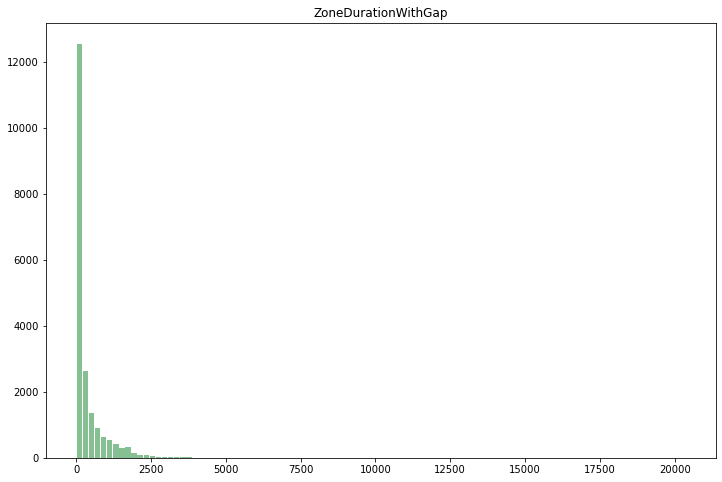

In [78]:
Zone_df_duration = zones_df[['ZoneId','ZoneDurationWithGap']]

ax = Zone_df_duration.hist(column='ZoneDurationWithGap', bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

Here we have the stay duration of all zones together, we need the distribution of the stay in each zone. In order to do that, we have to preprocess our data in order to drop all the rows where a person stay less than 5 seconds and more than one hour, we assume that a zone is important only when a person stays at least 5 seconds and we assume that no one stays more than a hour in the same zone

In [80]:
Zone_df_duration_bounded = Zone_df_duration.loc[Zone_df_duration['ZoneDurationWithGap'] > 5]
Zone_df_duration_bounded = Zone_df_duration_bounded.loc[Zone_df_duration_bounded['ZoneDurationWithGap'] < 3600]
Zone_df_duration_bounded_grouped = Zone_df_duration_bounded.groupby("ZoneId")

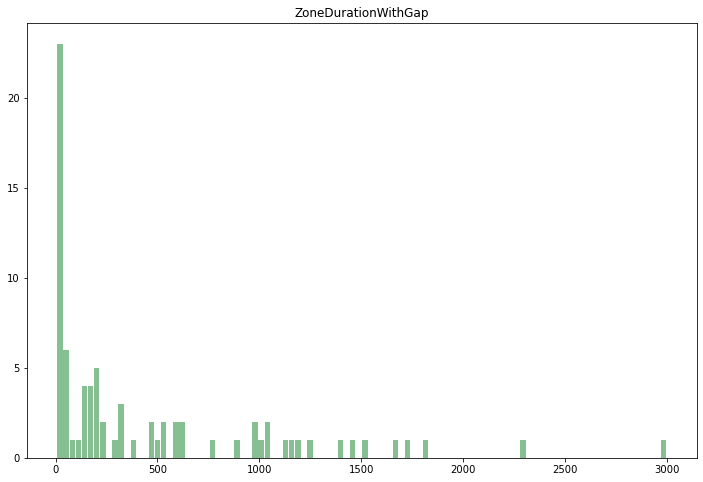

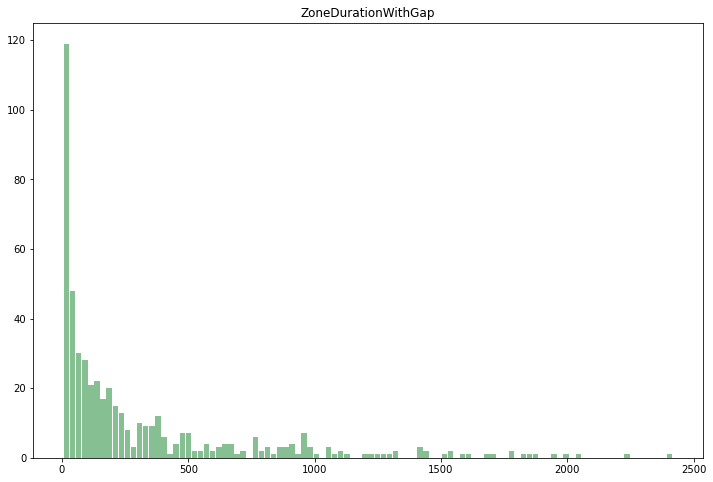

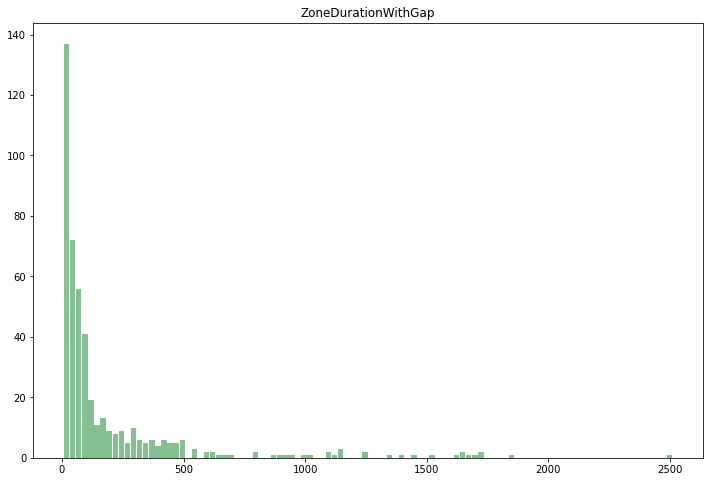

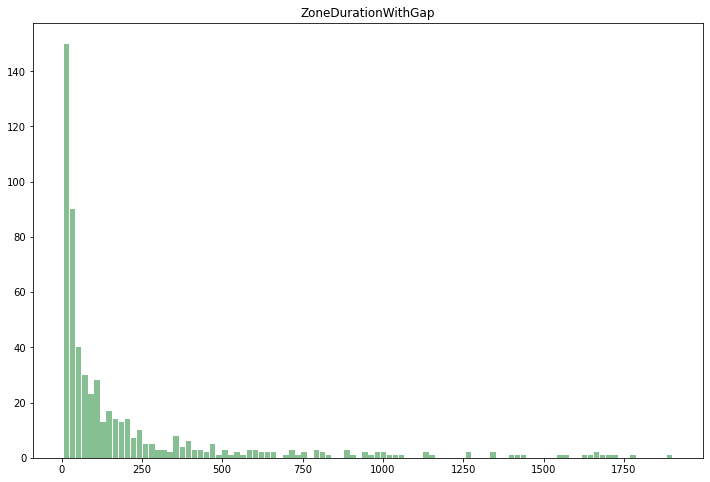

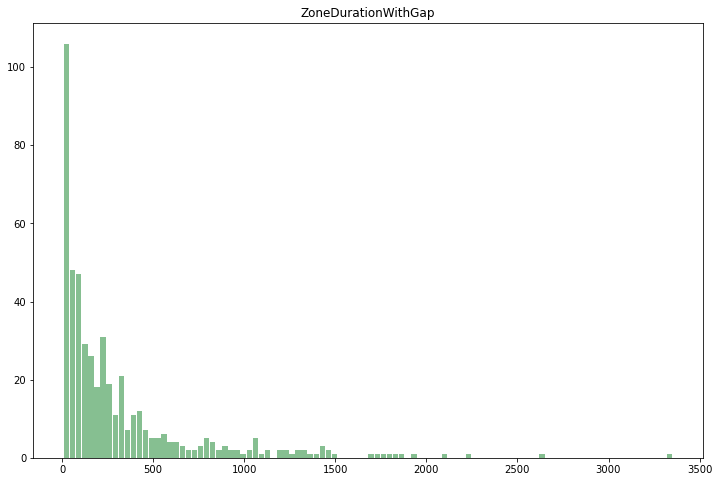

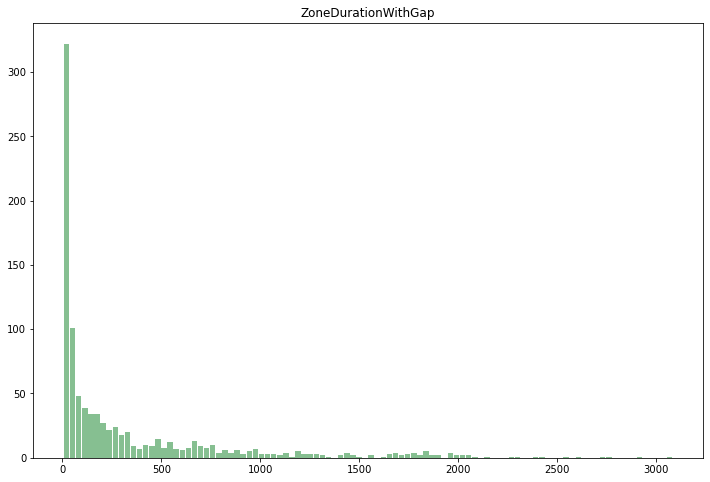

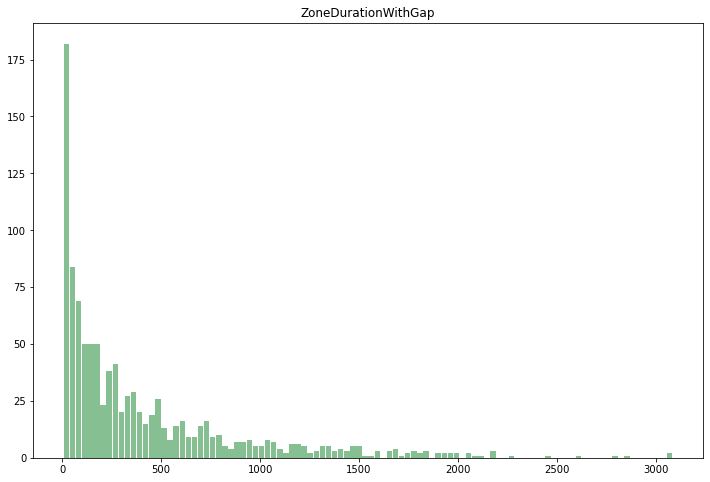

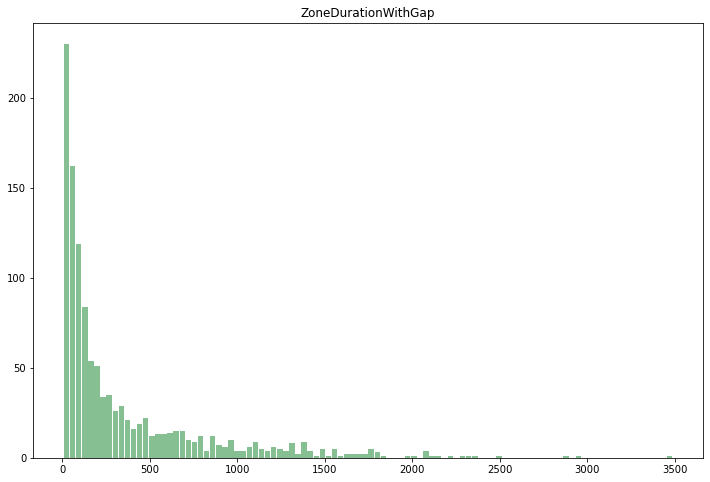

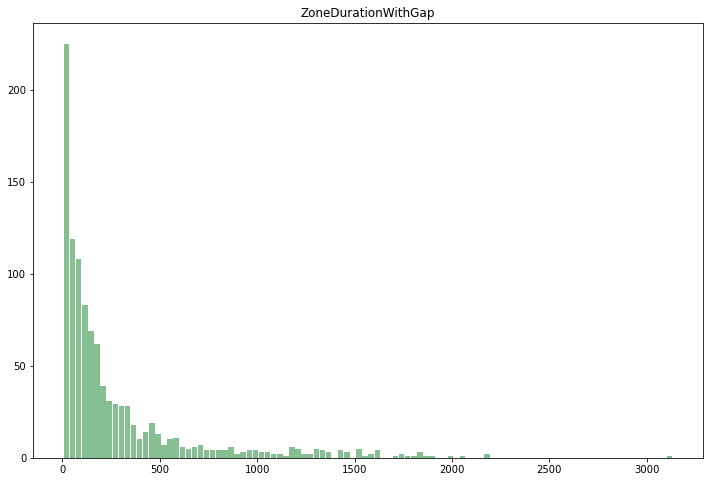

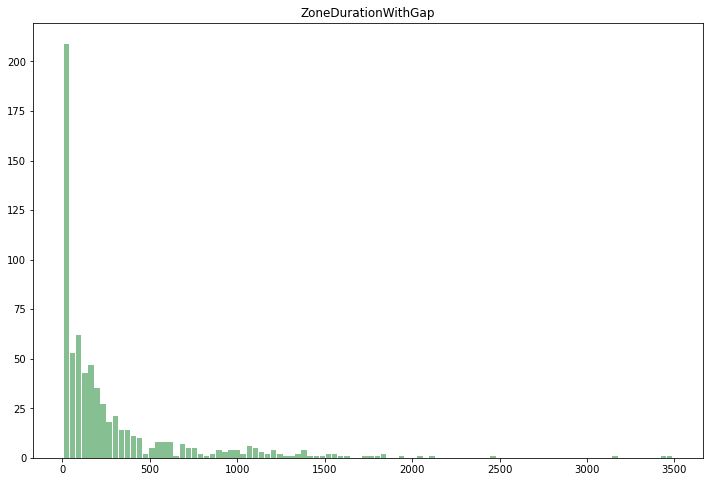

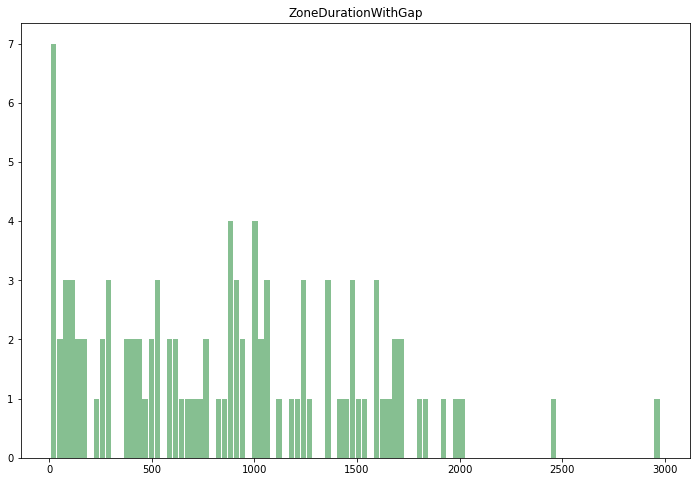

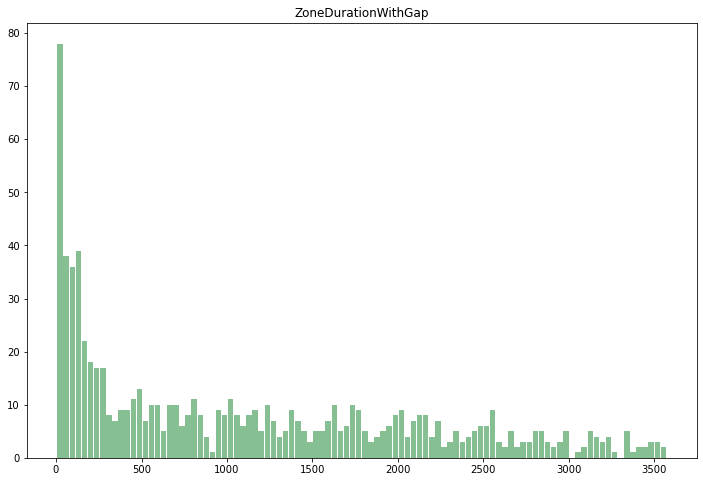

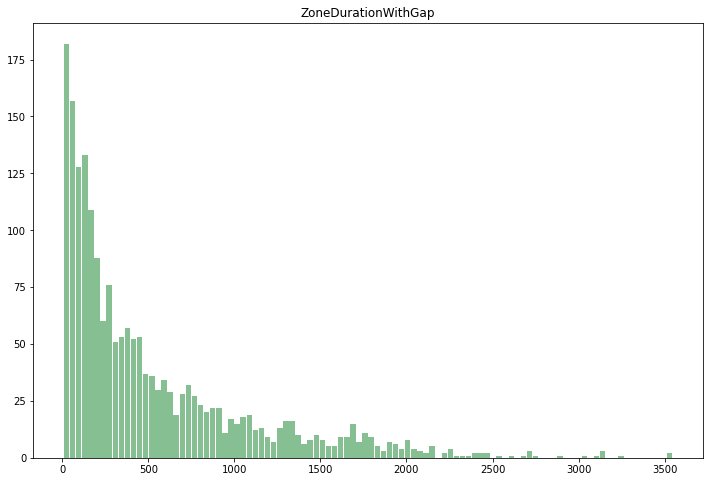

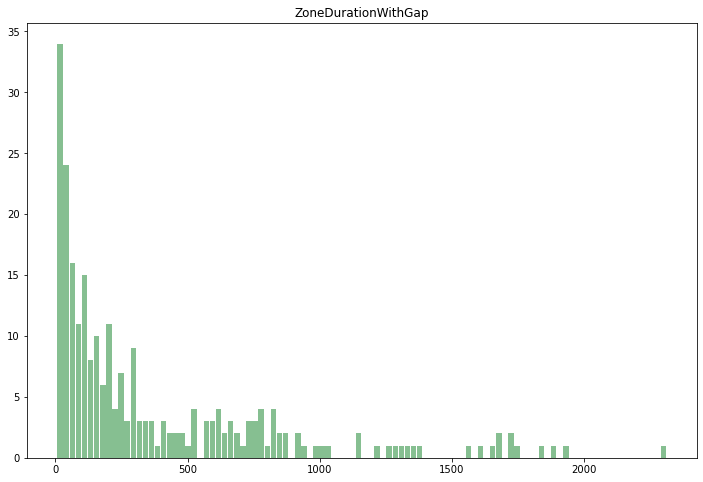

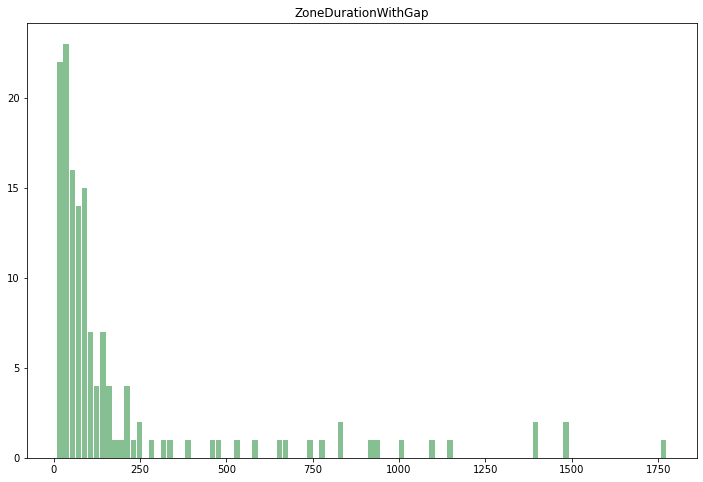

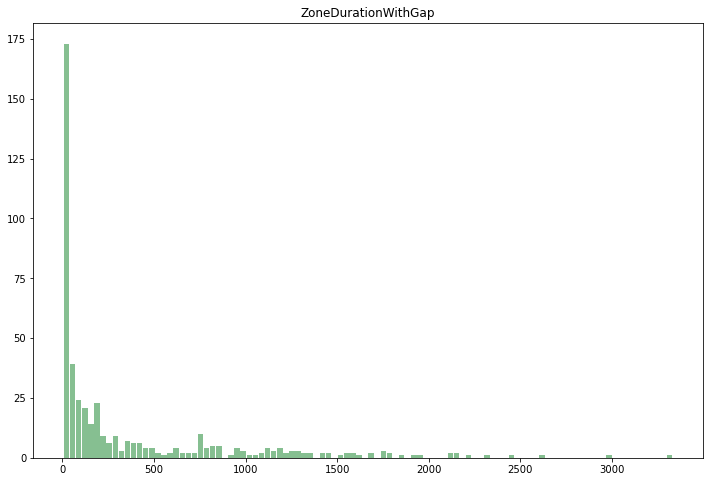

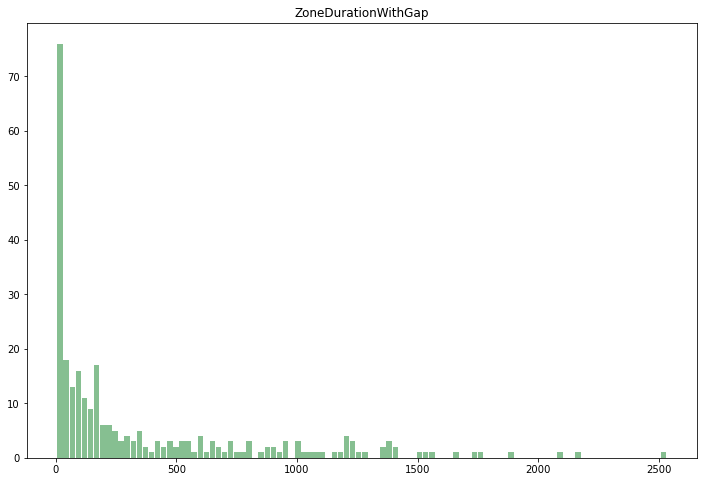

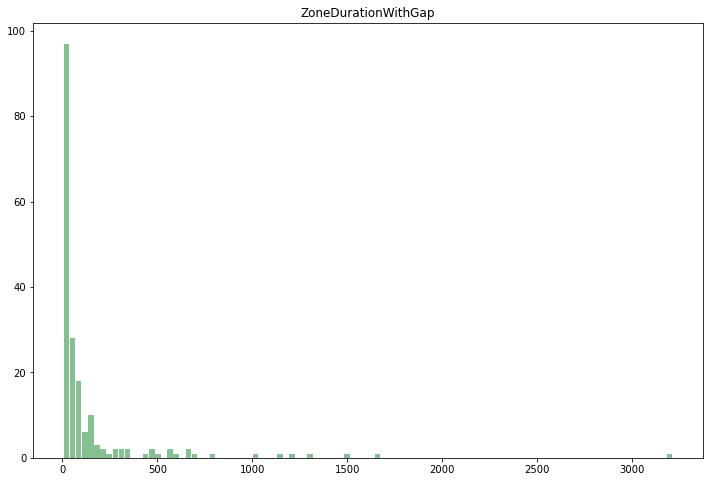

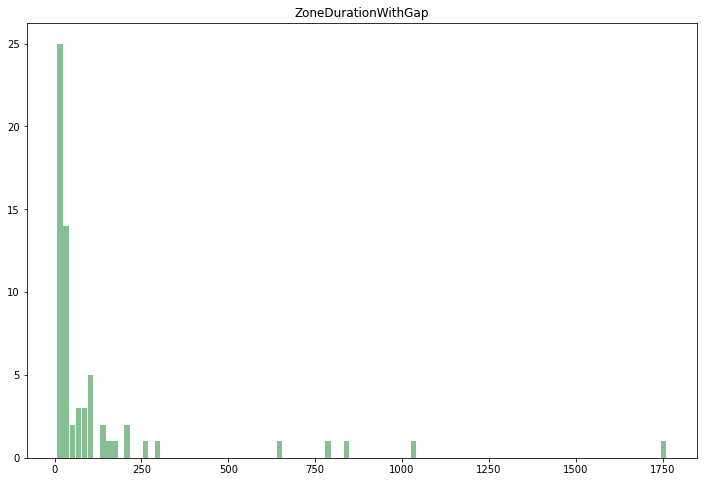

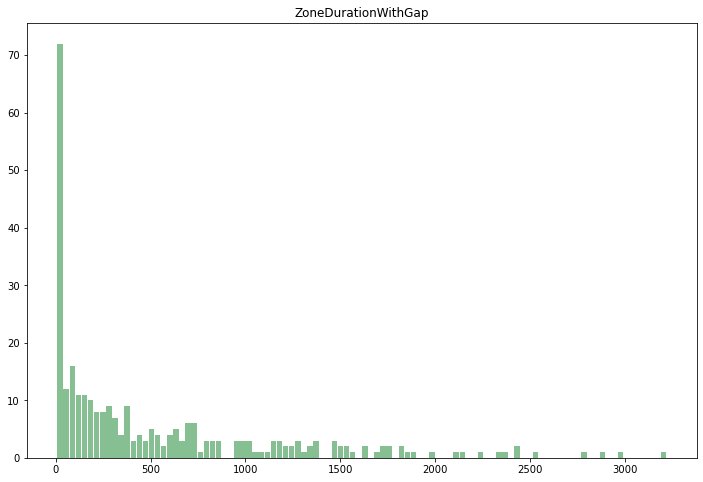

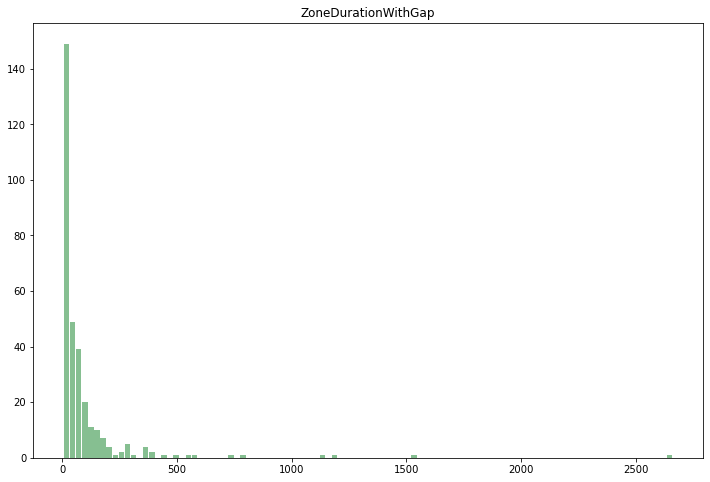

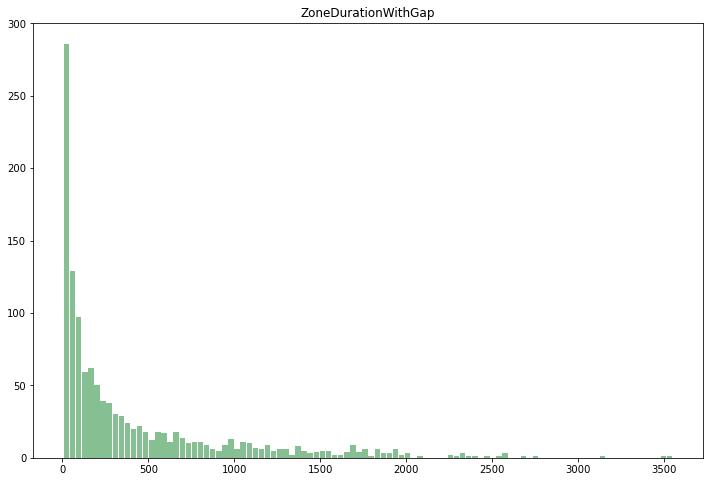

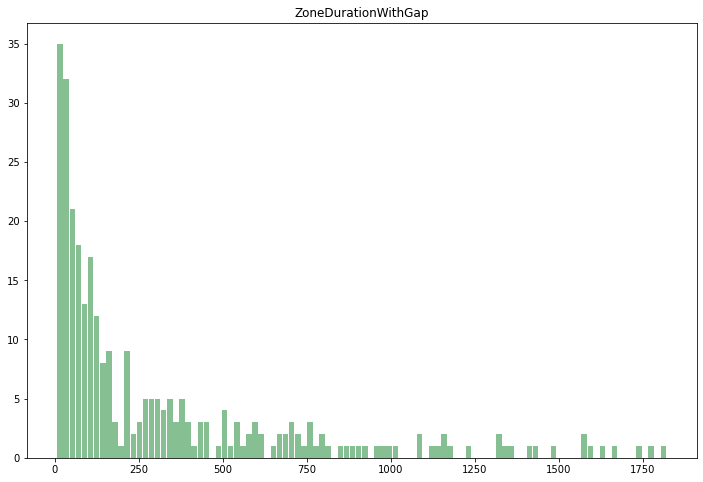

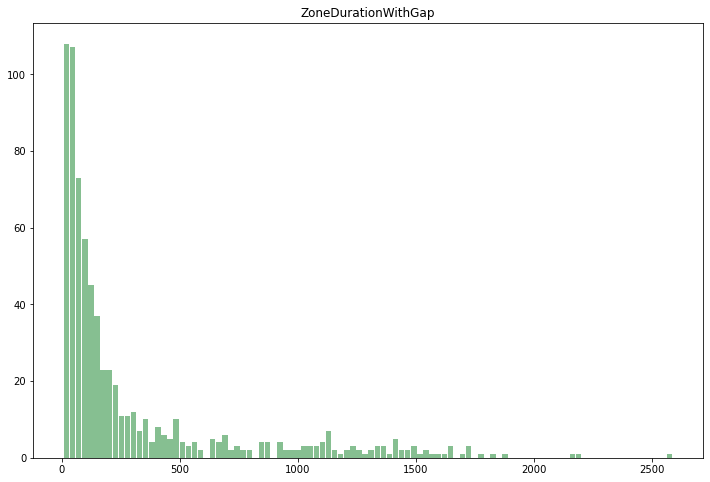

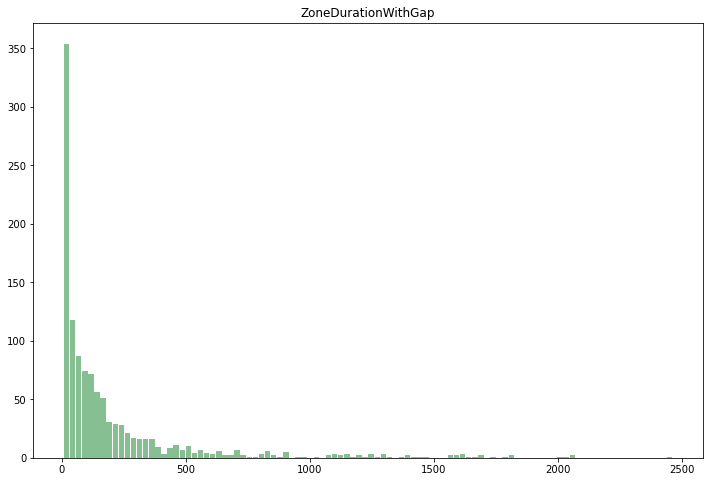

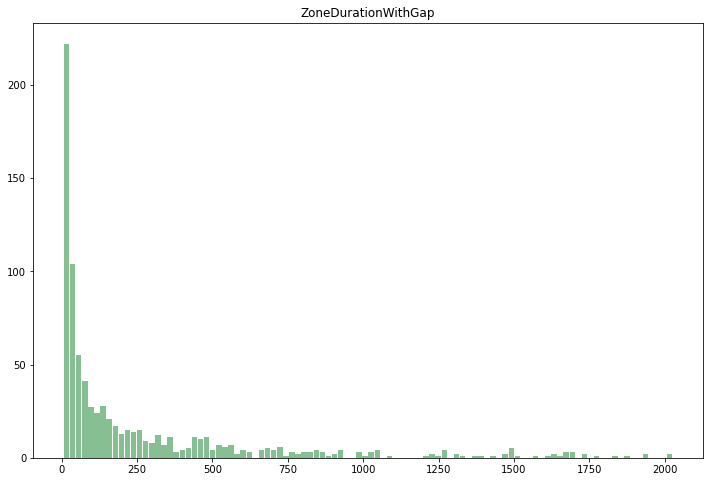

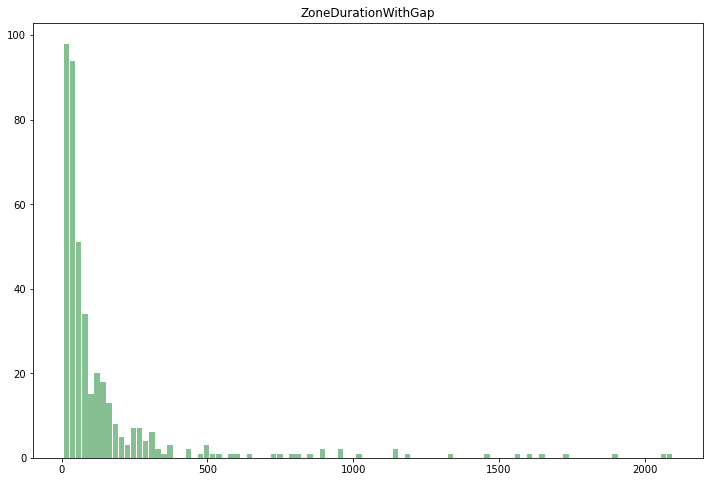

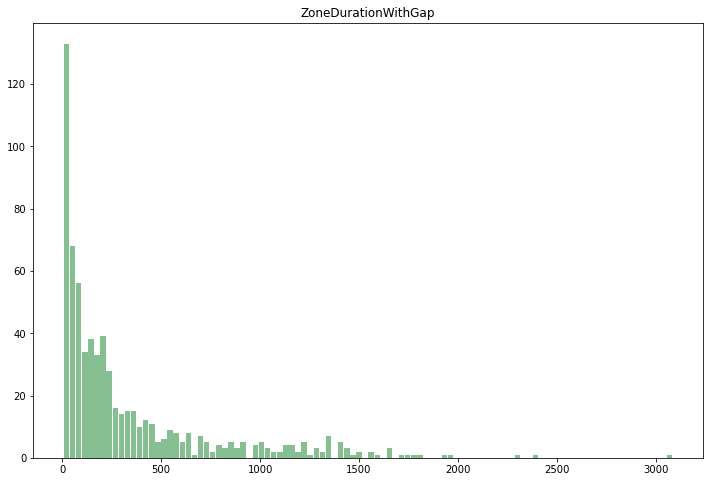

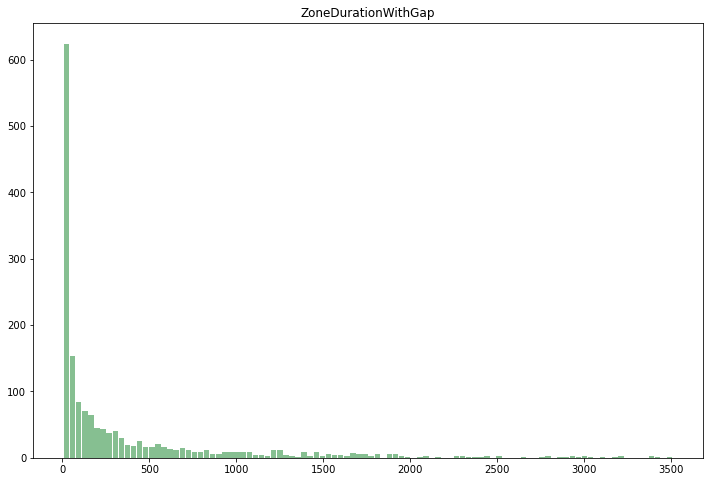

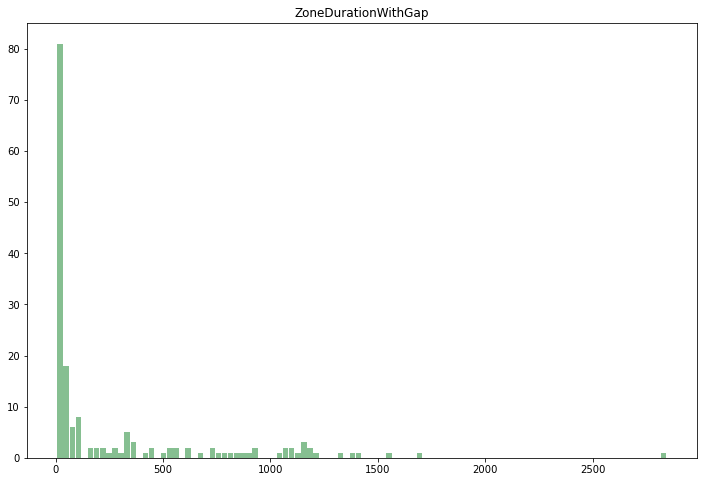

In [84]:
ax = Zone_df_duration_bounded_grouped.hist(column='ZoneDurationWithGap', bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)


We can see that almost every distribution (with some exceptions) follows the exponential distribution shown below

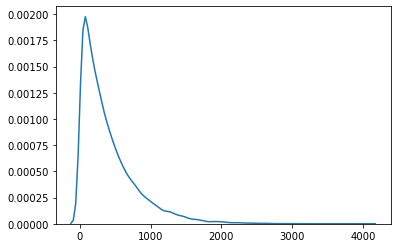

In [89]:
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(random.exponential(scale=400, size=Zone_df_duration_bounded.size ), hist=False)

plt.show()

This function will take as input a ZoneId and return a random duration

In [90]:
def generateDuration(zoneID):  
    if zoneID in Zone_df_duration_bounded['ZoneId']:##if the zone exists in our dataframe we'll generate a random duration according to the max duration spent in that zone previously
        maximum = Zone_df_duration_bounded.loc[Zone_df_duration_bounded['ZoneId'] == zoneID].max()
        zone_duration = random.exponential(scale=maximum['ZoneDurationWithGap']/10, size= 1)[0]
    else: #if not, we generate a random duration based on the max durention spent in all zones together
        maximum = Zone_df_duration_bounded['ZoneDurationWithGap'].max()
        zone_duration = random.exponential(scale=maximum/10, size= 1)
        
    return int(zone_duration)


We'll then write a function that, given a list of zoneID that represent a trajectory, we generate a duration zone for each one and we build a dictionnary with zoneId as keys and the duration stayed in each zone as values

In [91]:
def generateDurationFromTrajectory(trajectory):
    dictionnary = dict.fromkeys(trajectory,0)
    for i in trajectory:
        dictionnary[i] = generateDuration(i)
    return dictionnary

## trajectory generator
In this section we generate trajectories based on the artificial matrix. <br>
first, we define the number of all trajectories, each trajectory could be valid or note.  <br>
then, we draw one of the entrance zones, and iterate untill we arrive to one of the exit zones(valid trajectory) or to the maximum number of iterations( unvalid trajectory).

In [70]:
print("valid trajectories : ")
nbr_trajectory_candiate = 50 # number of all trajectories valid or not (iteration of the outer loop)

entrance_zones = [60888, 65023]
exit_zones = [70020, 65019, 65020, 65021, 60888, 65023]

trajectories_generated = [] # our valids trajectories 

for i in range(nbr_trajectory_candiate): 
    
    current_zone = random.choice(entrance_zones) # get one of the entrance zones
    
    trajectory_candiate = [] # valid and not valid trajectories
    trajectory_candiate.append(current_zone)
    max_ite = 30 # maxumum number of iteration of the inner loop
    ite = max_ite
    while current_zone not in exit_zones or ite == max_ite:   

        # destination zones takes only zones that are note null in our data frame, 
        # to get sure to choose a valide accessible zone comming from current_zone
        destination_zones = [int(zone) for zone in artificial_matrix.loc[str(current_zone)].index if artificial_matrix.loc[str(current_zone)][zone] > 0]
        
        zone_candidate = random.choice(destination_zones)# choose a random zoon from the destination zones

        trajectory_candiate.append(zone_candidate) # add the zone to the trajectory

        current_zone = zone_candidate
        
        if(ite == 0):
            break;
        ite -= 1
        
    if(current_zone in exit_zones):# add the trajectory if it's valid
        trajectories_generated.append(trajectory_candiate)
        print(trajectory_candiate)

print("number of trajectories : ", len(trajectories_generated))

valid trajectories : 
[65023, 60890, 60853, 60906, 60903, 60855, 70020]
[65023, 60890, 60892, 60908, 60906, 60910, 60852, 70017, 70010, 60904, 70010, 65004, 65003, 65004, 65005, 60902, 60909, 60847, 60909, 60910, 60852, 60855, 70020]
[60888, 60909, 60847, 60846, 70012, 70004, 60910, 60853, 60904, 60908, 60903, 60853, 60910, 60896, 60846, 60851, 60909, 60849, 60852, 60846, 60853, 60888]
[60888, 60904, 60910, 60850, 60889, 60888]
[65023, 60890, 60907, 60852, 60849, 60891, 60909, 60890, 60852, 60892, 70003, 60891, 60907, 60888]
[60888, 60892, 60910, 60902, 60848, 65008, 60910, 65008, 60895, 60894, 60910, 60853, 70017, 60853, 70017, 70010, 70017, 60853, 60904, 60911, 65004, 65005, 60902, 60904, 60888]
[65023, 60890, 60892, 60849, 60892, 60851, 70028, 65018, 70028, 65018, 65017, 60887, 60852, 60851, 60853, 60888]
[65023, 60890, 60893, 60849, 60908, 60888]
[65023, 60890, 60893, 60909, 60903, 60911, 65004, 60911, 60904, 60907, 60888]
[65023, 60890, 60892, 70003, 60893, 60902, 60903, 60910, 60

## Trajectory generation of weighted matrix
In this part we based ourselves on the probabilities of passage between two zones of the artificial matrix.we generate a random value based on the algorithm of Mersenne Twister known for its reliability and we compare this generated value with the probability between two zones of the artificial matrix (the more this probability is big the more we will have chance to make this transition).<br>
For the exit conditions we have 2 : 
<ul>
    <li> If you are on an exit zone, you have a 70% chance of getting out</li>
    <li> If the duration of the generated visit is >= 2 * the longest visit of the original dataset </li>
</ul>
Difficulties:
<ul>
    <li> Too many outliers in the dataset</li>
    <li> And only 30 zones out of 82 have a duration so 52 zones have never been used </li>
</ul>

In [99]:
Zone_df_duration = zones_df[['ZoneId','ZoneDurationWithGap']]
Zone_df_duration_bounded = Zone_df_duration.loc[Zone_df_duration['ZoneDurationWithGap'] > 5]
Zone_df_duration_bounded = Zone_df_duration_bounded.loc[Zone_df_duration_bounded['ZoneDurationWithGap'] < 3600]
Zone_df_duration_bounded_grouped = Zone_df_duration_bounded.groupby("ZoneId")
#This function will take as input a ZoneId and return a random duration
from numpy import random
def generateDuration(zoneID):  
    if zoneID in Zone_df_duration_bounded['ZoneId']:##if the zone exists in our dataframe we'll generate a random duration according to the max duration spent in that zone previously
        m = Zone_df_duration_bounded.loc[Zone_df_duration_bounded['ZoneId'] == zoneID].max()
        z = random.exponential(scale=m['ZoneDurationWithGap']/10, size= 1)[0]
    else: #if not, we generate a random duration based on the max durention spent in all zones together
        m = Zone_df_duration_bounded['ZoneDurationWithGap'].max()
        z = random.exponential(scale=m/10, size= 1)
        
    return int(z)

In [105]:
#a ne pas oublier combien de temps il y reste aussi si zone de sorti sortir forcément ou non je test avec oui ?
exit_zones = ['70020', '65019', '65020', '65021', '60887', '60911', '60910']
enter_area = ['60888', '65023']
max_visite_duration = 27697 * 2 #the duration limit of a generated visit will be 2*max_visit_duration
trajectories = []
duree_visite = 0
trajectories.append('60888')#adding enter area 65023 doesn't work
####################################################################################################################################
def GenerateWithProbability(enter):
    y = 0
    if(len(trajectories) > 100) :
        return
    if(duree_visite > max_visite_duration):
        print('hello')
    for i in range(1000):
        if(random.random() < artificial_weighted_matrix.loc[enter][y]) :
            if(artificial_weighted_matrix.columns[y] in exit_zones): #if exit zone add the zone to finish the trajectory and add exit to  recognize it later
                trajectories.append(artificial_weighted_matrix.columns[y])
                trajectories.append('exit')
                trajectories.append('60888')
                GenerateWithProbability('60888') #recursive call with one of the enter zone
            else :
                trajectories.append(artificial_weighted_matrix.columns[y])
                GenerateWithProbability(artificial_weighted_matrix.columns[y])
        else :
            if(y<81) :
                y = y+1
            else :
                y=0
####################################################################################################################################

In [106]:
GenerateWithProbability('60888')

In [107]:
def treatment_output(trajectories) :
    size = len(trajectories)
    idx_list = [idx + 1 for idx, val in
                enumerate(trajectories) if val == 'exit']
    trajectories = [trajectories[i: j] for i, j in
            zip([0] + idx_list, idx_list + 
            ([size] if idx_list[-1] != size else []))]
    trajectories.remove(trajectories[len(trajectories)-1])
    #for i in range (len(trajectories)-1):
        #trajectories = list(dict.fromkeys(trajectories))
    return trajectories
    

In [115]:
generated_weighted_trajectories = treatment_output(trajectories)
print("number of generated trajectories : ",len(generated_weighted_trajectories))
generated_weighted_trajectories[:10]

number of generated trajectories :  81


[['60888', '60887', 'exit'],
 ['60888', '60887', 'exit'],
 ['60888', '60889', '60888', '60887', 'exit'],
 ['60888',
  '65017',
  '60888',
  '60853',
  '70017',
  '60853',
  '60854',
  '60902',
  '60904',
  '60906',
  '70011',
  '60903',
  '60904',
  '60852',
  '60904',
  '60852',
  '70017',
  '60851',
  '60906',
  '60851',
  '60850',
  '60907',
  '60891',
  '60906',
  '60851',
  '60906',
  '70011',
  '60904',
  '65004',
  '65005',
  '65004',
  '65005',
  '65004',
  '60904',
  '60906',
  '60891',
  '60906',
  '60903',
  '60902',
  '60906',
  '60902',
  '60854',
  '60902',
  '60911',
  'exit'],
 ['60888',
  '65018',
  '65017',
  '70026',
  '65017',
  '70028',
  '70023',
  '70028',
  '70029',
  '70029',
  '70028',
  '70028',
  '70024',
  '70003',
  '70024',
  '70006',
  '70003',
  '70028',
  '70023',
  '70002',
  '60892',
  '60891',
  '60906',
  '60891',
  '60906',
  '60903',
  '60904',
  '65004',
  '65003',
  '65002',
  '65003',
  '65002',
  '65003',
  '65004',
  '65003',
  '60911',
  'e

In [119]:
formated_trajectories = []
for trajectory in generated_weighted_trajectories:
    trajectory.pop()
    formated_trajectories.append(generateDurationFromTrajectory(trajectory))
    
formated_trajectories[:5]

[{},
 {},
 {'60888': 236, '60889': 22},
 {'60888': 435,
  '65017': 123,
  '60853': 905,
  '70017': 90,
  '60854': 22,
  '60902': 21,
  '60904': 177,
  '60906': 1004,
  '70011': 4,
  '60903': 76,
  '60852': 526,
  '60851': 16,
  '60850': 633,
  '60907': 76,
  '60891': 396,
  '65004': 1429,
  '65005': 1429},
 {'60888': 383,
  '65018': 258,
  '65017': 192,
  '70026': 1010,
  '70028': 1401,
  '70023': 578,
  '70029': 46,
  '70024': 583,
  '70003': 162,
  '70006': 242,
  '70002': 34,
  '60892': 164,
  '60891': 741,
  '60906': 145,
  '60903': 940,
  '60904': 109,
  '65004': 110,
  '65003': 1376,
  '65002': 119}]

## Generaliz Sequential Pattern using original data

In [96]:

from gsppy.gsp import GSP

min_size = 2 # The minimum length of a visit to concider

visits = [l for l in new_zone_list if len(l) > min_size] # assign visits that have length above min_size

result = GSP(visits).search(0.06)
result


[{(60852,): 671,
  (60902,): 556,
  (60888,): 523,
  (60904,): 545,
  (60854,): 393,
  (60853,): 621,
  (60906,): 603,
  (60849,): 308,
  (60903,): 241,
  (60891,): 285,
  (60908,): 305,
  (60910,): 563,
  (60896,): 205,
  (60848,): 208,
  (60895,): 177,
  (60909,): 412,
  (60889,): 141,
  (60850,): 378,
  (60907,): 342,
  (60892,): 177,
  (60893,): 132,
  (60851,): 582,
  (60846,): 288,
  (60847,): 204,
  (60911,): 162},
 {(60846, 60910): 136,
  (60847, 60910): 128,
  (60848, 60910): 164,
  (60850, 60907): 214,
  (60851, 60852): 246,
  (60851, 60906): 191,
  (60852, 60853): 163,
  (60852, 60851): 262,
  (60852, 60904): 212,
  (60853, 60854): 158,
  (60853, 60852): 215,
  (60853, 60902): 193,
  (60854, 60853): 162,
  (60854, 60902): 207,
  (60888, 60853): 115,
  (60891, 60906): 144,
  (60896, 60910): 119,
  (60902, 60853): 185,
  (60902, 60854): 181,
  (60902, 60911): 106,
  (60904, 60852): 162,
  (60904, 60903): 116,
  (60904, 60906): 103,
  (60906, 60851): 184,
  (60906, 60891): 125,

## Generelize Sequential Pattern using artificial data

In [98]:

result = GSP(trajectories_generated).search(0.06)
result

[{(65023,): 21,
  (60903,): 13,
  (60855,): 7,
  (70020,): 3,
  (60890,): 23,
  (60892,): 11,
  (60908,): 8,
  (60910,): 15,
  (60852,): 13,
  (70017,): 3,
  (65004,): 3,
  (60904,): 11,
  (60902,): 11,
  (60909,): 7,
  (60847,): 6,
  (60888,): 38,
  (60846,): 11,
  (70012,): 5,
  (70004,): 4,
  (60896,): 8,
  (60851,): 12,
  (60849,): 17,
  (60850,): 11,
  (60853,): 13,
  (60889,): 7,
  (60907,): 13,
  (70003,): 3,
  (60891,): 14,
  (60906,): 10,
  (60848,): 7,
  (60895,): 6,
  (65008,): 3,
  (60911,): 5,
  (60887,): 8,
  (60893,): 7,
  (60854,): 7},
 {(60849, 60891): 3,
  (60849, 60908): 3,
  (60852, 60849): 3,
  (60853, 60888): 3,
  (60855, 70020): 3,
  (60888, 60907): 3,
  (60890, 60850): 3,
  (60890, 60888): 4,
  (60890, 60892): 4,
  (60907, 60888): 4,
  (65023, 60890): 20,
  (70012, 60896): 3},
 {(65023, 60890, 60850): 3,
  (65023, 60890, 60892): 4,
  (65023, 60890, 60888): 4}]

## Statisctics

In [9]:

#######################################################################################################################


# The timestamps have indeed been transformed from string to datetime:
#print(visits_df.at[0,'Zones'][0]['Zone Begin At'])
#print(zones_df.loc[0,'Zone Begin At'])

# How to put records corresponding to a particular period of 'Begin At' in a new dataframe:
#zones_df.index = zones_df['ZoneBeginAt']
#zones_df_3days = zones_df['2017-05-19':'2017-05-21'].copy()
#zones_df = zones_df.reset_index(drop=True)
#print(zones_df_3days.head(3))

#######################################################################################################################
# HANDLING THE DATA AND CALCULATING STATISTICS (Examples)
#######################################################################################################################

# The data by now have been conveniently stored in two dataframes:

# In the 1st dataframe, each row represets a visit:
print(visits_df.head(5))
print(visits_df.columns)
print(visits_df.dtypes)

# In the 2nd dataframe, each row represets a zone detection:
print(zones_df.head(5))
print(zones_df.columns)
print(zones_df.dtypes)

# How to group the data by User Id:
#series_user_groups = zones_df.groupby(zones_df['UserId'])
#print(series_user_groups)

# How to put records corresponding to a particular period of 'Begin At' in a new dataframe:
#zones_df.index = zones_df['ZoneBeginAt']
#zones_df_3days = zones_df['2017-05-19':'2017-05-21'].copy()
#zones_df = zones_df.reset_index(drop=True)
#print(zones_df_3days.head(3))

# Characteristic values of the "ZoneDuration" distribution, corresponding to how long a visitor was detected in each zone:
# The mean:
print(zones_df.ZoneDuration.mean())
# The mean after filtering out instances of "ZoneDuration" equal to 0:
print(zones_df['ZoneDuration'][lambda x: x!=0].mean())
# The standard deviation:
#print(zones_df.ZoneDuration.std())
# The standard deviation after filtering out instances of "ZoneDuration" equal to 0:
#print(zones_df['ZoneDuration'][lambda x: x!=0].std())
# The median:
#print(zones_df.ZoneDuration.median()) # equivalent to: print(zones_df.ZoneDuration.quantile(0.5))
# The median after filtering out instances of "ZoneDuration" equal to 0:
#print(zones_df['ZoneDuration'][lambda x: x!=0].median())
# Various percentiles:
print(zones_df.ZoneDuration.quantile([.01, .10, .25, .50, .75 , .90, .99]))
# Various percentiles after filtering out instances of "ZoneDuration" equal to 0:
print(zones_df['ZoneDuration'][lambda x: x!=0].quantile([.01, .10, .25, .50, .75, .90, .99]))

# Characteristic values of the "ZoneDurationWithGap" distribution, corresponding to the period between the start of two consecutive zone detections:
# The mean:
print(zones_df.ZoneDurationWithGap.mean())
# The mean after filtering out instances of ZoneDuration equal to 0:
print(zones_df['ZoneDurationWithGap'][lambda x: x!=0].mean())
# The standard deviation:
#print(zones_df.ZoneDurationWithGap.std())
# The standard deviation after filtering out instances of "ZoneDuration" equal to 0:
#print(zones_df['ZoneDurationWithGap'][lambda x: x!=0].std())
# The median:
#print(zones_df.ZoneDurationWithGap.median()) # equivalent to: print(zones_df.ZoneDuration.quantile(0.5))
# The median after filtering out instances of ZoneDuration equal to 0:
#print(zones_df['ZoneDurationWithGap'][lambda x: x!=0].median())
# Various percentiles:
print(zones_df.ZoneDurationWithGap.quantile([.01, .10, .25, .50, .75 , .90, .99]))
# Various percentiles after filtering out instances of ZoneDuration equal to 0:
print(zones_df['ZoneDurationWithGap'][lambda x: x!=0].quantile([.01, .10, .25, .50, .75, .90, .99]))

# Visualize the two distributions:

# Create the intervals over the (horizontal) time axis:
domain = np.linspace(0,2000,1000)
# Get a reference to the current figure:
figg = plt.gcf()
# Change the name of the current figure:
figg.canvas.set_window_title('Normal Distribution')

# Taking into account all duration values:
#pdf1 = norm.pdf(domain, zones_df.ZoneDuration.mean(), zones_df.ZoneDuration.std())
# Better yet, ignoring 0 duration values (as errors):
pdf2 = norm.pdf(domain, zones_df['ZoneDuration'][lambda x: x!=0].mean(), zones_df['ZoneDuration'][lambda x: x!=0].std())
# Plot pdf (y-axis) versus domain (x-axis):
plt.plot(domain, pdf2, c='b', linestyle='-')

# Taking into account all duration values:
#pdf3 = norm.pdf(domain, zones_df.ZoneDurationWithGap.mean(), zones_df.ZoneDurationWithGap.std())
# Better yet, ignoring 0 duration values (as errors):
pdf4 = norm.pdf(domain, zones_df['ZoneDurationWithGap'][lambda x: x!=0].mean(), zones_df['ZoneDurationWithGap'][lambda x: x!=0].std())
# Plot pdf (y-axis) versus domain (x-axis):
plt.plot(domain, pdf4, c='r', linestyle='--')

plt.title("Normal distribution of zone stay duration")
plt.xlabel("Time (sec)")
plt.ylabel("Density")
plt.legend(('detection only', 'detection + gap'), loc='lower left')

# Display all figures and blocks until the figures have been closed:
#plt.show()

# Histogram example:
# bin_values = np.arange(start=0, stop=2000, step=100)
# zones_df['ZoneDuration'].hist(bins=bin_values, figsize=[14,6])
# Percentile values example:
# plt.plot(zones_df['ZoneDurationWithGap'][lambda x: x!=0].quantile([.01, .10, .25, .50, .75, .90, .99]))

#######################################################################################################################
# HANDLE and VISUALIZE INDIVIDUAL VISITOR DATA (Example)
#######################################################################################################################

# Find records corresponding to a particular 'User Id' (either given as a command line argument or at random) and put them in a new dataframe:
if len(sys.argv) > 1:
	given_user_id = sys.argv[1]
else:
	example = zones_df['UserId'].sample()
	given_user_id = example.iloc[0]
given_user = zones_df['UserId'] == given_user_id
zones_df_1user = zones_df[given_user].copy()
#print(zones_df_1user.sort_values(by='ZoneBeginAt'))

# Check here for plotting styles: https://fr.mathworks.com/help/matlab/ref/plot.html
zones_df_1user.plot(y = 'ZoneId', x = 'ZoneBeginAt', style='bo:')

# Get a reference to the current figure:
fig = plt.gcf()
# Change the name of the current figure:
fig.canvas.set_window_title('Scatter Plot of the ZoneId and ZoneBeginAt timestamp for a given UserId')

# Define the axes labels:
max_zone_id = zones_df['ZoneId'].max()
min_zone_id = zones_df['ZoneId'].min()
yint = range(min_zone_id-1, max_zone_id+1, 1)
plt.yticks(yint)
plt.ylabel('ZoneId')

# Display all figures and blocks until the figures have been closed:
#plt.show()

#######################################################################################################################
# CLEAR FIGURES
#######################################################################################################################

fig.clear()
figg.clear()

                  Id  User Id                   Begin At Duration Positions                                              Zones
0  14859677952946378  2946378  2017-02-01 16:49:55+00:00     6057       403  [{'ZoneBeginAt': 2017-02-01 16:49:55+00:00, 'Z...
1  14883584032946378  2946378  2017-03-01 08:53:23+00:00        9         3  [{'ZoneBeginAt': 2017-03-01 08:53:23+00:00, 'Z...
2  14885292222946378  2946378  2017-03-03 08:20:22+00:00     3613       231  [{'ZoneBeginAt': 2017-03-03 08:20:22+00:00, 'Z...
3  14903809872946378  2946378  2017-03-24 18:43:07+00:00     1029        65  [{'ZoneBeginAt': 2017-03-24 18:43:07+00:00, 'Z...
4  14920083432996102  2996102  2017-04-12 14:45:43+00:00       18        16  [{'ZoneBeginAt': 2017-04-12 14:45:43+00:00, 'Z...
Index(['Id', 'User Id', 'Begin At', 'Duration', 'Positions', 'Zones'], dtype='object')
Id           object
User Id      object
Begin At     object
Duration     object
Positions    object
Zones        object
dtype: object
    UserId       

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [1]:
zones_df

NameError: name 'zones_df' is not defined

# Notes
weka </br>
data inputation </br>
regle d'association seque,tiel ... temporelle spad, fpetry </br>
par ou on commence - entries </br>
fonction aleatoir dans une destribution numérique </br>
tirage aleatoir dans une distribution numérique </br>
esq changement d'etage et frequent plusieurs fois dans une visiste </br>

En rajoutant le matrice d'adjacence; on inculra à la fin dans les trajectoires les zone non detectable (ex : 70028)